# Pipeline #3 - Statistical analyses

<img src="img/pipeline3.png" width="550"/>


This final phase of the project addresses our main question: 

**Is there a PD subtype associated with faster cognitive and neural decline?**

To answer this question, statistical analyses will be run to compare the identified subtypes on their cognitive and neural decline. 

**Another disclaimer:** the term *'decline'* implies a progression over time, which is what this project aims to measure. However, due to current data accessibility constraints, cognitive measures for only one time point are available. Moreover, since a majority of MRI scans have not yet undergone processing, neural decline data remains unavailable. Consequently, for this deliverable, analyses will be conducted solely using cognition scores from a single time point. It is important to note that the results obtained from thoses analyses therefore don't match our original research question. Once all data accessible, comparisons will involve assessing declines in both measures over multiple time points. 

## Pipeline overview

This pipeline implements basic statistical analyses in Python to compare groups. The idea is once again to have a template of some tests that will be run once we get the final clustering and imaging results. Specifically, this pipeline performs the following tasks:

- Descriptive statistics
- Statistical tests
- Visualization of results

In [64]:
# Loading librairies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from scipy.stats import f_oneway
import scikit_posthocs as sp

from scipy.stats import linregress
from matplotlib.pyplot import cm

# Provide path to results on which to run analyses
prelim_results = pd.read_excel('/Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/results/841/841.xlsx', sheet_name="3st") 

## Descriptive statistics

Let's take a look at our results from the descriptive aspect.

How many participants in each group?

In [43]:
# subtype 0
st_0 = prelim_results[prelim_results['ml_subtype'] == 0]

# subtype 1
st_1 = prelim_results[prelim_results['ml_subtype'] == 1]

# subtype 2
st_2 = prelim_results[prelim_results['ml_subtype'] == 2]

participants_count = prelim_results['ml_subtype'].value_counts()

print("Number of participants in each group:")
print(participants_count)

Number of participants in each group:
ml_subtype
0    409
1    316
2    231
Name: count, dtype: int64


Computes descriptive statistics such as mean, median, standard deviation, etc., for each subtype identified previously.

In [27]:
print(prelim_results.groupby('ml_subtype')[['Age', 'Onset', 'Duration', 'Hoehn', 'MoCA']].describe())

              Age                                                     Onset  \
            count       mean       std   min   25%   50%   75%   max  count   
ml_subtype                                                                    
0           389.0  67.187661  8.661638  39.0  62.0  68.0  74.0  88.0  382.0   
1           299.0  66.026756  9.453487  38.0  60.5  67.0  73.0  90.0  295.0   
2           217.0  66.161290  9.642056  36.0  60.0  67.0  73.0  86.0  215.0   

                       ... Hoehn        MoCA                                  \
                 mean  ...   75%  max  count       mean       std  min   25%   
ml_subtype             ...                                                     
0           60.819372  ...   3.0  4.0  361.0  24.944598  5.347090  0.0  24.0   
1           59.610169  ...   3.0  5.0  275.0  25.123636  5.056540  0.0  24.0   
2           60.488372  ...   3.0  5.0  204.0  25.264706  5.239912  0.0  24.0   

                              
             

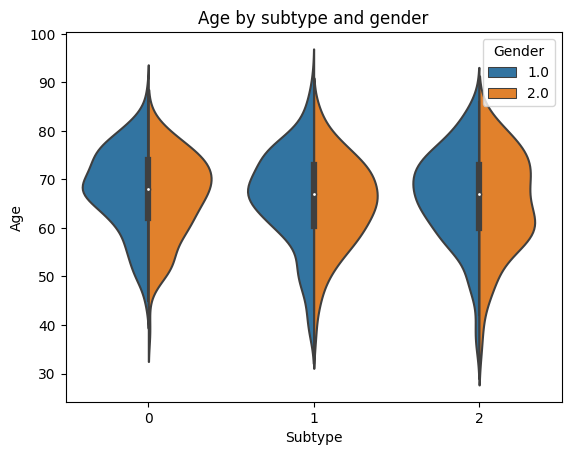

In [31]:
# Let's look at the age, by subtype and gender

sns.violinplot(x='ml_subtype', y='Age', hue='Gender', data=prelim_results, split=True)
plt.title('Age by subtype and gender')
plt.xlabel('Subtype')
plt.ylabel('Age')
plt.legend(title='Gender', loc='best')
plt.show()

The groups look similar...differences are hard to tell visually. Statistical analyses will confirm if there are significant differences.

## Statistical tests and results visualization

Conducts appropriate statistical tests to compare groups on their cognitive decline and neural decline, and visualize the results graphically.

- **Cognitive** decline measured with MoCA scores
- **Neural** decline measured with cortical thickness and volume data

We saw in early analyses that the MoCA score was **not normally distributed** accross the COPN dataset:

<img src="img/moca_skewed.png"/>

A solution would be to perform non-parametric tests when analyzing the cognition variable. An appropriate test is the **Kruskal-Wallis test with Bonferroni correction** for multiple comparisons. 

In [37]:
# Perform Kruskal-Wallis test
stat, p_value = kruskal(st_0.dropna()['MoCA'].to_numpy(), st_1.dropna()['MoCA'].to_numpy(), st_2.dropna()['MoCA'].to_numpy())

# Adjust p-values using Bonferroni correction
no_comparisons = 3
adjusted_p_values = multipletests([p_value], method='bonferroni')[1]

print(f"Kruskal-Wallis Test statistic: {stat:.4f}")
print(f"Raw p-value: {p_value:.4f}")
print(f"Adjusted p-value (Bonferroni): {adjusted_p_values[0]:.4f}")

if adjusted_p_values[0] < 0.05:
    print("Reject null hypothesis: Groups have different medians.")
else:
    print("Fail to reject null hypothesis: No significant difference in medians.")

Kruskal-Wallis Test statistic: 3.8109
Raw p-value: 0.1488
Adjusted p-value (Bonferroni): 0.1488
Fail to reject null hypothesis: No significant difference in medians.


Here, the difference between subtypes in cognition at one time point is not significant. 

Let's look at the variable 'Age' that we plotted earlier. Since the age follow a normal distribution, let's run a quick ANOVA with 

In [51]:
# Perform ANOVA
stat, p_value = f_oneway(st_0.dropna()['Age'].to_numpy(), st_1.dropna()['Age'].to_numpy(), st_2.dropna()['Age'].to_numpy())

print(f"One-way ANOVA F-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

data = [st_0.dropna()['Age'],
        st_1.dropna()['Age'],
        st_2.dropna()['Age']]

# If significant, perform posthoc comparisons with Dunn's test (holm corrected)
p_values = sp.posthoc_dunn(data, p_adjust='holm')

print(p_values)

One-way ANOVA F-statistic: 3.0066
P-value: 0.0505
          1         2         3
1  1.000000  0.149182  0.312913
2  0.149182  1.000000  0.712782
3  0.312913  0.712782  1.000000


Here again, the age does not differ accross the identified subtypes. 

Now, what would be more interesting to look at are the differences accross subtypes for the clinical measures, aka the non-motor symptoms, the data used to perform the initial clustering. There definitely should be differences between groups on the different symptoms, otherwise, they wouldn't have been classified into clusters...yes or no? 

Let's assess, and plot only the symptoms with significant differences accross subtypes. 

Groups have significatively different means for Anxiety.


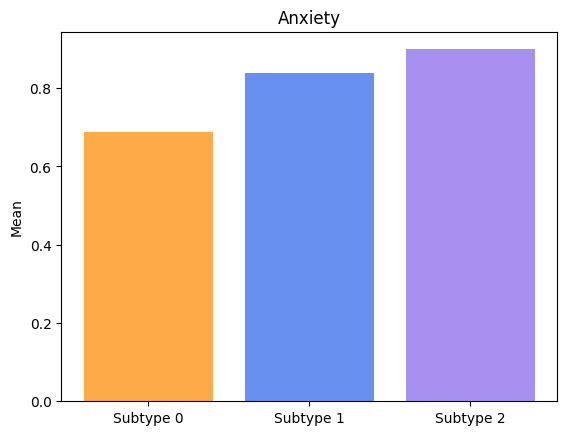

Groups have significatively different means for Apathy.


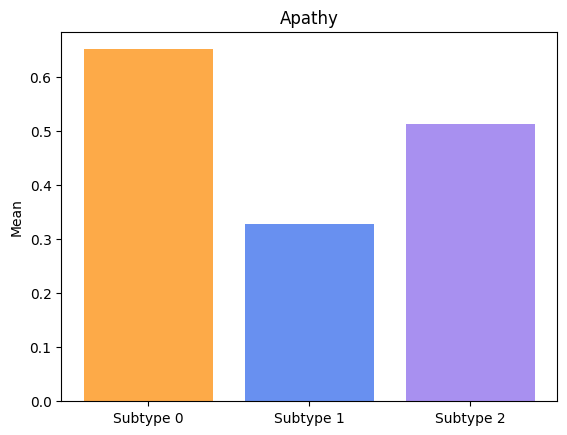

Groups have significatively different means for Insomnia.


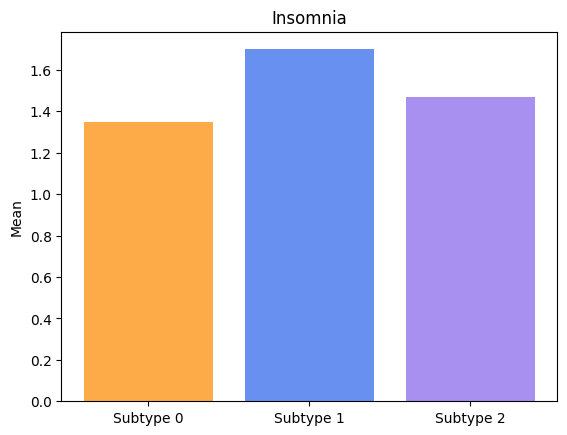

Groups have significatively different means for Constipation.


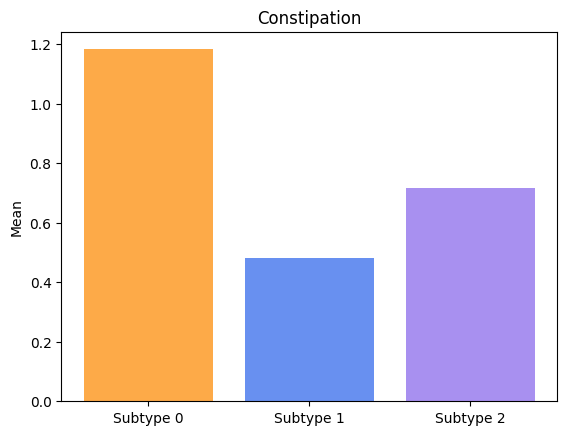

Groups have significatively different means for Speech.


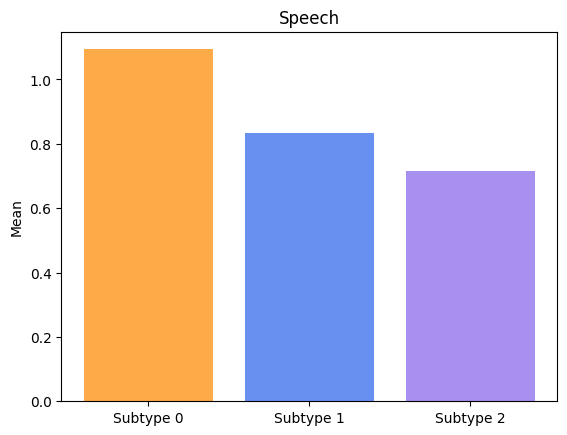

Groups have significatively different means for Drooling.


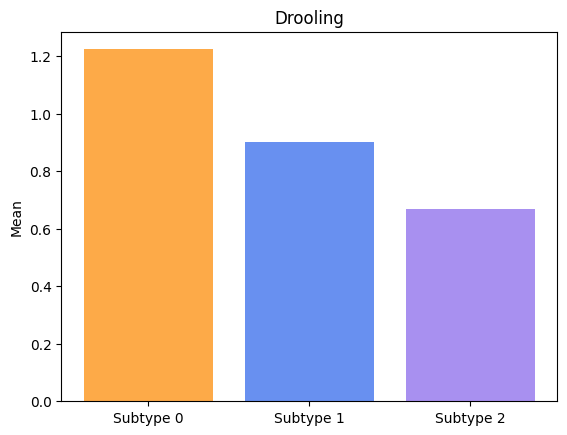

Groups have significatively different means for Swallowing.


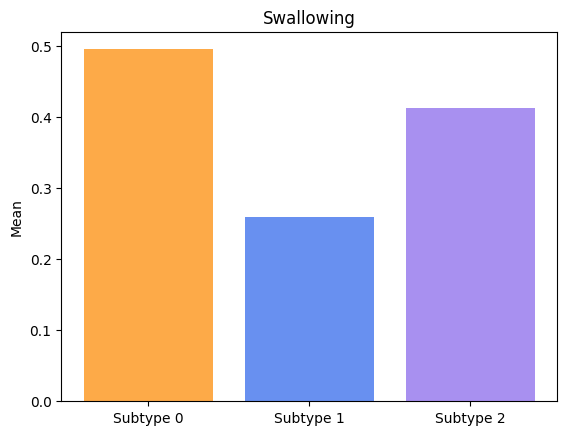

Groups have significatively different means for Handwriting.


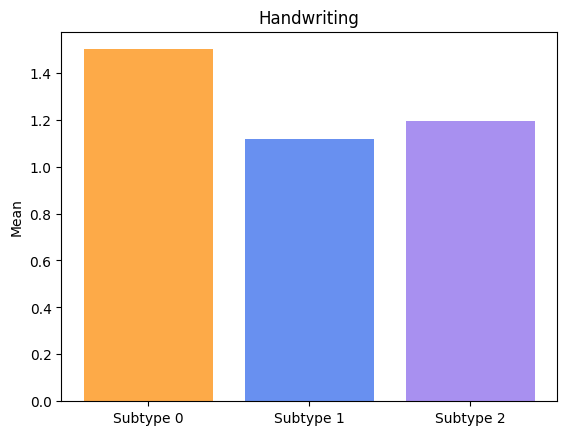

Groups have significatively different means for Rolling.


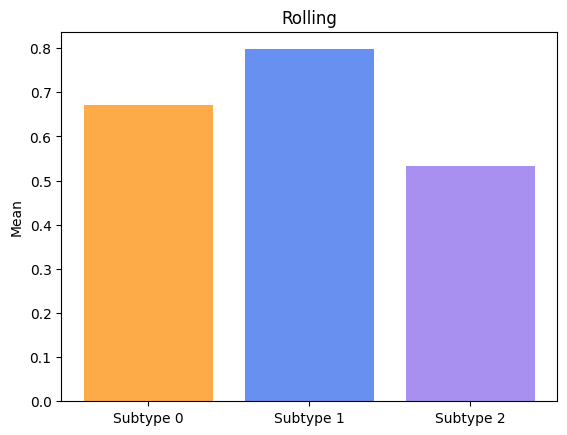

Groups have significatively different means for Tremor.


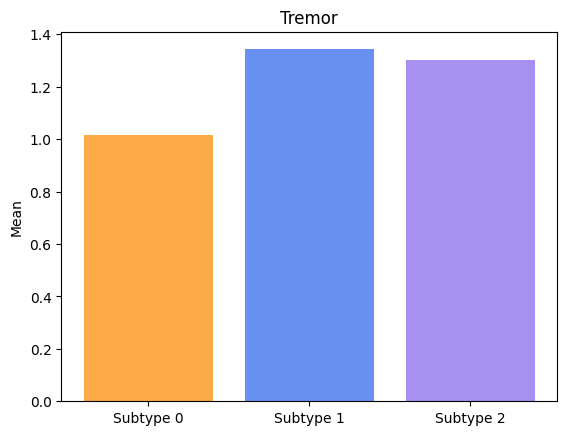

Groups have significatively different means for Arising.


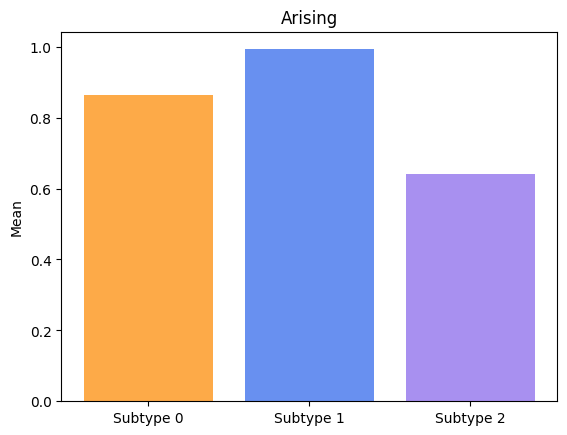

Groups have significatively different means for Freezing.


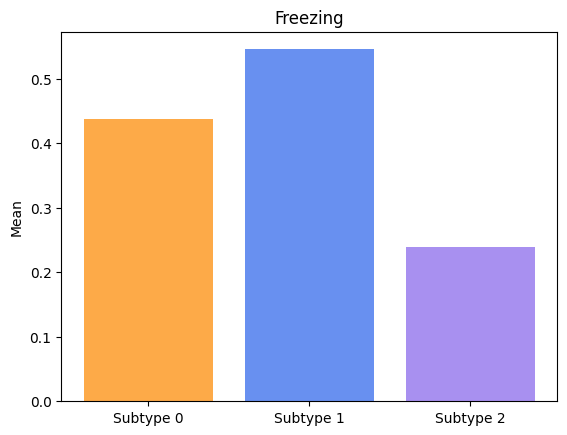

In [63]:
biomarkers = ['Cognition', 'Psychosis', 'Depression', 'Anxiety', 'Apathy',
            'Impulsivity', 'Insomnia', 'Sleepiness', 'Pain', 'Incontinence',
            'Constipation', 'Dizziness', 'Fatigue', 'Speech', 'Drooling',
            'Swallowing', 'Eating', 'Dressing', 'Hygiene', 'Handwriting', 'Hobbies',
            'Rolling', 'Tremor', 'Arising', 'Walking', 'Freezing']

categories = ['Subtype 0', 'Subtype 1', 'Subtype 2']

for biomarker in biomarkers:

    st_0_lst = st_0.dropna()[biomarker].to_numpy()
    st_1_lst = st_1.dropna()[biomarker].to_numpy()
    st_2_lst = st_2.dropna()[biomarker].to_numpy()

    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(st_0_lst, st_1_lst, st_2_lst)

    # Adjust p-values using Bonferroni correction
    no_comparisons = 3
    adjusted_p_values = multipletests([p_value], method='bonferroni')[1]

    # print(f"Kruskal-Wallis Test statistic for " + biomarker + ": {stat:.4f}")
    # print(f"Raw p-value: {p_value:.4f}")
    # print(f"Adjusted p-value (Bonferroni): {adjusted_p_values[0]:.4f}")

    if adjusted_p_values[0] < 0.05:
        
        print("Groups have significatively different means for " + biomarker + ".")

        # Plotting
        values = [np.mean(st_0_lst), np.mean(st_1_lst), np.mean(st_2_lst)]
        fig, ax = plt.subplots()
        ax.bar(categories, values, color=['#fdaa48','#6890F0','#A890F0'])
        ax.set_ylabel('Mean')
        ax.set_title(biomarker)

        plt.show()

Lastly, let's visualize the symptoms progressions for each subtype.

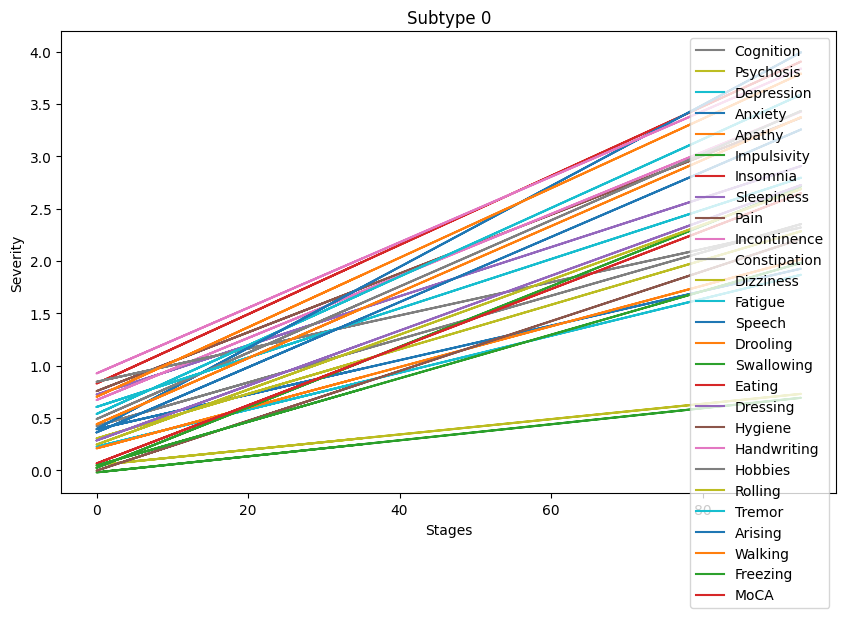

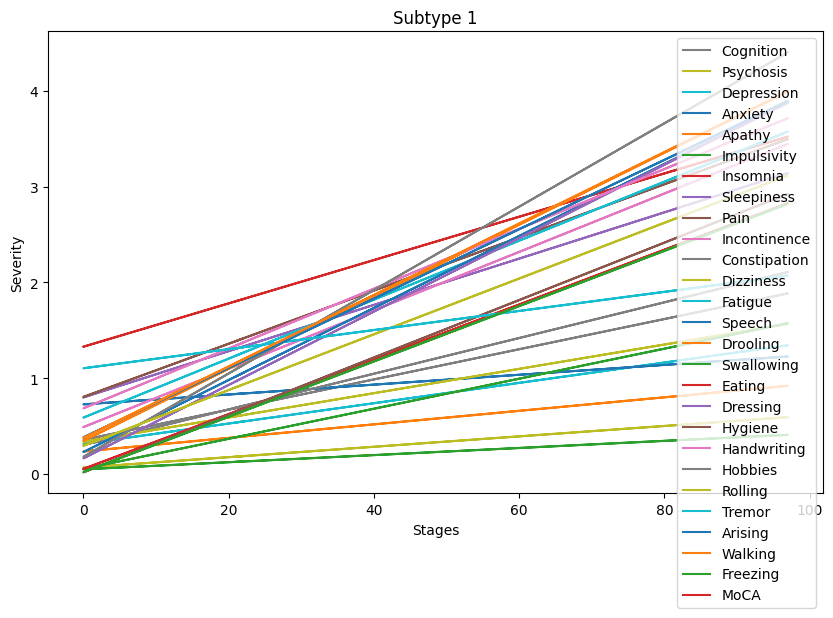

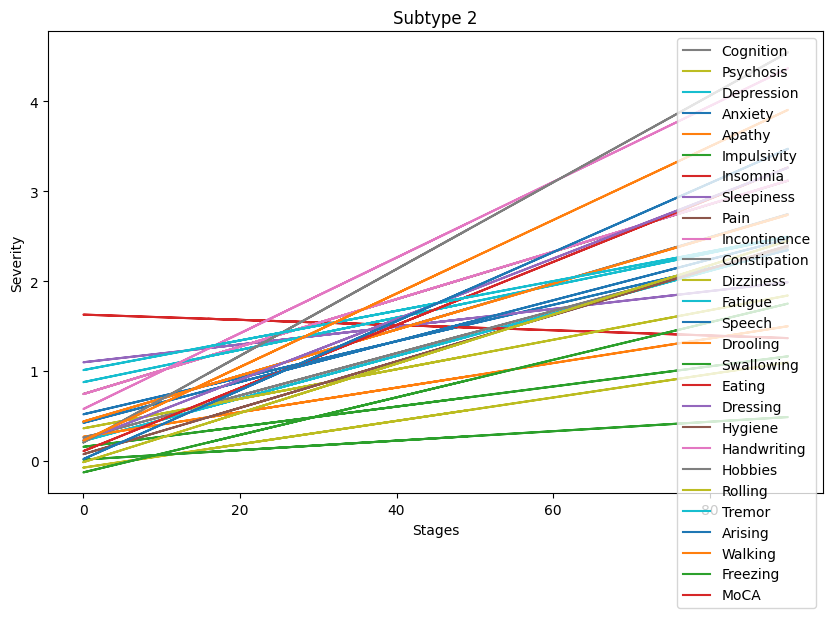

In [84]:
# Define colors for markers
color_all = (plt.cm.tab10.colors[:26]) * 4 

st_lst = [st_0, st_1, st_2]
for i in range (3):
    st = st_lst[i]
    stage = st["ml_stage"].to_numpy()
    fig= plt.figure(figsize=(10,6))
    plt.title("Subtype " + str(i))
    plt.xlabel("Stages")
    plt.ylabel("Severity")

    marker_names = list(st)

    for j in range(7, 34): 
        marker_name = marker_names[j]
        marker_data = st[marker_name].to_numpy()

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(stage, marker_data)

        # Create a regression line
        regression_line = slope * stage + intercept

        color = iter(cm.rainbow(np.linspace(0, 1, 27)))

        plt.plot(stage, regression_line, color=color_all[j], label=marker_name)
        plt.legend()

    plt.legend()
    plt.show()

Progression patterns of non-motor symptoms seem to differ between subtypes. A deeper analysis comparing progression trends for each symptom is necessary to identify exact progression trends identified by the clustering algorithm. 

## Conclusion

Writting this pipeline provided good practice in conducting basic statistical analyses and data visualization using Python packages. While there is room for improvement in terms of code cleanliness and efficiency, this pipeline serves as a good code foundation for the statistical comparisons that will be conducted in the project.

Collectively, the three pipelines, along with the skills acquired through BH School, allowed for a comprehensive exploration of the toolkit for successfully completing the project’s objectives.

A special thanks to Marie for your time, patience, and for sharing invaluable knowledge that will greatly contribute to the success of the project!